<a href="https://colab.research.google.com/github/Swagat-modder/DataScience-Analytics-projects/blob/main/Food%20delivery%20and%20CP%20analysis/Food_Delivery_CP_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A food delivery service is facing challenges in achieving profitability across its operations. With a dataset of 1,000 food orders, the service seeks to understand the dynamics of its cost structure and profitability to identify strategic opportunities for improvement.

The dataset contains comprehensive details on food orders, including Order ID, Customer ID, Restaurant ID, Order and Delivery Date and Time, Order Value, Delivery Fee, Payment Method, Discounts and Offers, Commission Fee, Payment Processing Fee, and Refunds/Chargebacks. This data provides a foundation for analyzing the cost structure and profitability of the food delivery service.

Your task is to conduct:


*  Detailed Cost Analysis: Identifying the major cost components associated with delivering food orders, including direct costs like delivery fees and indirect costs like discounts and payment processing fees.

*  Profitability Evaluation: Calculating the profitability of individual orders and aggregating this data to assess overall profitability. This involves examining how revenue generated from commission fees measures against the total costs.
*  Strategic Recommendations for Improvement: Based on the cost and profitability analysis, identifying actionable strategies to reduce costs, adjust pricing, commission fees, and discount strategies to improve profitability. This includes finding a “sweet spot” for commission and discount percentages that ensures profitability across orders.


*  Impact Simulation of Proposed Strategies: Simulating the financial impact of the recommended strategies on profitability, using the dataset to forecast how adjustments in commission rates and discount strategies could potentially transform current losses into profits.


In [1]:
pip install fireducks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [2]:
import fireducks.pandas as pd
food_orders = pd.read_csv("/content/food_orders_new_delhi.csv")
food_orders.head()

,Order ID,Customer ID,Restaurant ID,Order Date and Time,Delivery Date and Time,Order Value,Delivery Fee,Payment Method,Discounts and Offers,Commission Fee,Payment Processing Fee,Refunds/Chargebacks
0,1,C8270,R2924,2024-02-01 01:11:52,2024-02-01 02:39:52,1914,0,Credit Card,5% on App,150,47,0
1,2,C1860,R2054,2024-02-02 22:11:04,2024-02-02 22:46:04,986,40,Digital Wallet,10%,198,23,0
2,3,C6390,R2870,2024-01-31 05:54:35,2024-01-31 06:52:35,937,30,Cash on Delivery,15% New User,195,45,0
3,4,C6191,R2642,2024-01-16 22:52:49,2024-01-16 23:38:49,1463,50,Cash on Delivery,None,146,27,0
4,5,C6734,R2799,2024-01-29 01:19:30,2024-01-29 02:48:30,1992,30,Cash on Delivery,50 off Promo,130,50,0


In [3]:
food_orders.isnull().sum()

Order ID                  0
Customer ID               0
Restaurant ID             0
Order Date and Time       0
Delivery Date and Time    0
Order Value               0
Delivery Fee              0
Payment Method            0
Discounts and Offers      0
Commission Fee            0
Payment Processing Fee    0
Refunds/Chargebacks       0
dtype: int64

In [4]:
# converting date and time columns to datetime
food_orders['Order Date and Time'] = pd.to_datetime(food_orders['Order Date and Time'])
food_orders['Delivery Date and Time'] = pd.to_datetime(food_orders['Delivery Date and Time'])

# first, let's create a function to extract numeric values from the 'Discounts and Offers' string
def extract_discount(discount_str):
    if 'off' in discount_str:
        # Fixed amount off
        return float(discount_str.split(' ')[0])
    elif '%' in discount_str:
        # Percentage off
        return float(discount_str.split('%')[0])
    else:
        # No discount
        return 0.0

# applying the function to create a new 'Discount Value' column
food_orders['Discount Percentage'] = food_orders['Discounts and Offers'].apply(lambda x: extract_discount(x))

# for percentage discounts, calculating the discount amount based on the order value
food_orders['Discount Amount'] = food_orders.apply(lambda x: (x['Order Value'] * x['Discount Percentage'] / 100)
                                                   if x['Discount Percentage'] > 1
                                                   else x['Discount Percentage'], axis=1)

# adjusting 'Discount Amount' for fixed discounts directly specified in the 'Discounts and Offers' column
food_orders['Discount Amount'] = food_orders.apply(lambda x: x['Discount Amount'] if x['Discount Percentage'] <= 1
                                                   else x['Order Value'] * x['Discount Percentage'] / 100, axis=1)

print(food_orders[['Order Value', 'Discounts and Offers', 'Discount Percentage', 'Discount Amount']].head(), food_orders.dtypes)

   Order Value Discounts and Offers  Discount Percentage  Discount Amount
0         1914            5% on App                  5.0            95.70
1          986                  10%                 10.0            98.60
2          937         15% New User                 15.0           140.55
3         1463                 None                  0.0             0.00
4         1992         50 off Promo                 50.0           996.00 Order ID                           int64
Customer ID                       object
Restaurant ID                     object
Order Date and Time       datetime64[ns]
Delivery Date and Time    datetime64[ns]
Order Value                        int64
Delivery Fee                       int64
Payment Method                    object
Discounts and Offers              object
Commission Fee                     int64
Payment Processing Fee             int64
Refunds/Chargebacks                int64
Discount Percentage              float64
Discount Amount        

In [7]:
#Cost and profitability analysis
# calculate total costs and revenue per order
food_orders['Total Costs'] = food_orders['Delivery Fee'] + food_orders['Payment Processing Fee'] + food_orders['Discount Amount']
food_orders['Revenue'] = food_orders['Commission Fee']
food_orders['Profit'] = food_orders['Revenue'] - food_orders['Total Costs']

# aggregate data to get overall metrics
total_orders = food_orders.shape[0]
total_revenue = food_orders['Revenue'].sum()
total_costs = food_orders['Total Costs'].sum()
total_profit = food_orders['Profit'].sum()

overall_metrics = {
    "Total Orders": total_orders,
    "Total Revenue": total_revenue,
    "Total Costs": total_costs,
    "Total Profit": total_profit
}

print(overall_metrics)

{'Total Orders': 1000, 'Total Revenue': np.int64(126990), 'Total Costs': np.float64(232709.85), 'Total Profit': np.float64(-105719.84999999999)}


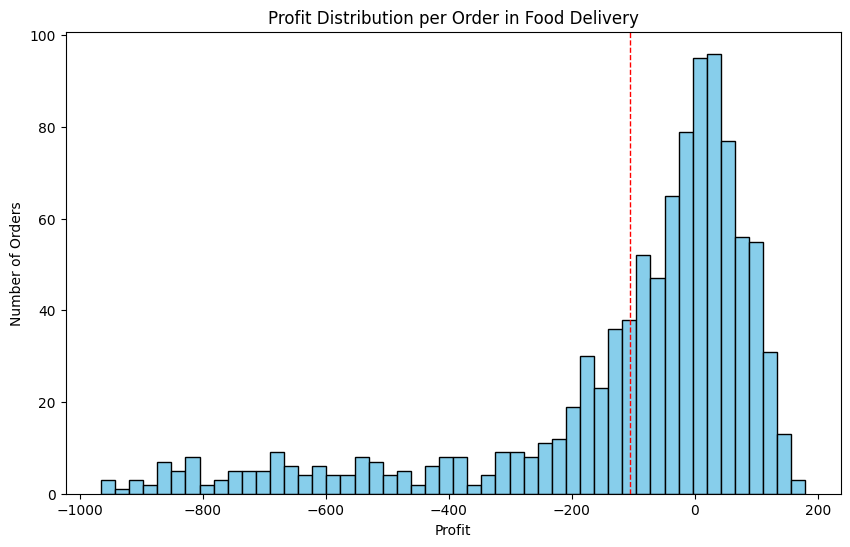

In [8]:
import matplotlib.pyplot as plt

# histogram of profits per order
plt.figure(figsize=(10, 6))
plt.hist(food_orders['Profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Profit Distribution per Order in Food Delivery')
plt.xlabel('Profit')
plt.ylabel('Number of Orders')
plt.axvline(food_orders['Profit'].mean(), color='red', linestyle='dashed', linewidth=1)
plt.show()

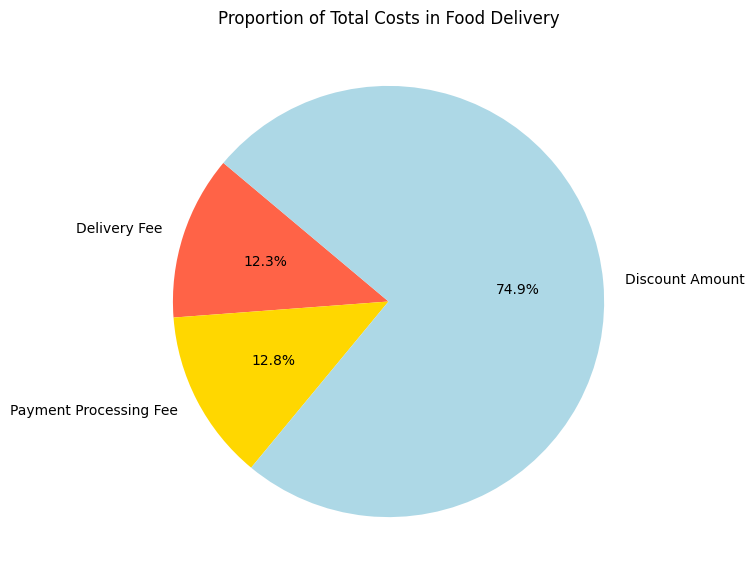

In [9]:
# pie chart for the proportion of total costs
costs_breakdown = food_orders[['Delivery Fee', 'Payment Processing Fee', 'Discount Amount']].sum()
plt.figure(figsize=(7, 7))
plt.pie(costs_breakdown, labels=costs_breakdown.index, autopct='%1.1f%%', startangle=140, colors=['tomato', 'gold', 'lightblue'])
plt.title('Proportion of Total Costs in Food Delivery')
plt.show()

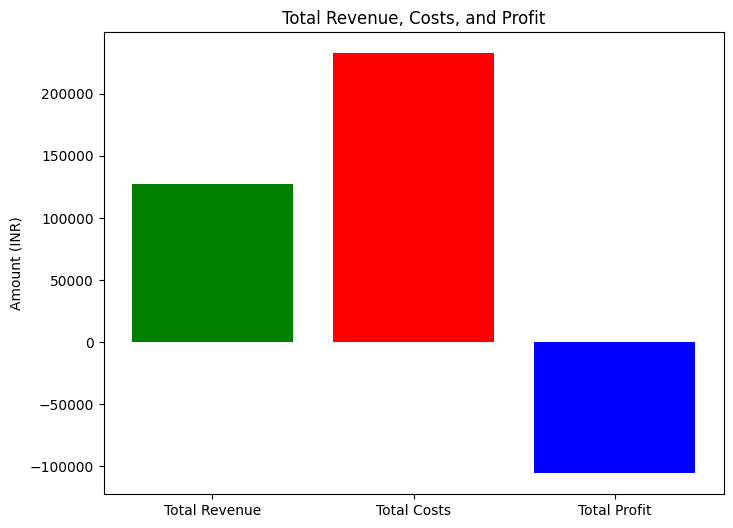

In [10]:
# bar chart for total revenue, costs, and profit
totals = ['Total Revenue', 'Total Costs', 'Total Profit']
values = [total_revenue, total_costs, total_profit]

plt.figure(figsize=(8, 6))
plt.bar(totals, values, color=['green', 'red', 'blue'])
plt.title('Total Revenue, Costs, and Profit')
plt.ylabel('Amount (INR)')
plt.show()

From the analysis so far we understood that the discounts on food orders are resulting in huge losses. Now, we need to find a new strategy for profitability. We need to find a sweet spot for offering discounts and charging commissions. To find a sweet spot for commission and discount percentages, we can analyze the characteristics of profitable orders more deeply. Specifically, we need to look for:




*   A new average commission percentage based on profitable orders.
*   A new average discount percentage for profitable orders, that could serve as a guideline for what level of discount still allows for profitability.

Given these new averages, we can suggest adjustments that might not only make individual orders profitable but also apply broadly across all orders to improve overall profitability. Let’s calculate:



*  The average commission percentage for profitable orders.
*  The average discount percentage for profitable orders.




In [11]:
# filter the dataset for profitable orders
profitable_orders = food_orders[food_orders['Profit'] > 0]

# calculate the average commission percentage for profitable orders
profitable_orders['Commission Percentage'] = (profitable_orders['Commission Fee'] / profitable_orders['Order Value']) * 100

# calculate the average discount percentage for profitable orders
profitable_orders['Effective Discount Percentage'] = (profitable_orders['Discount Amount'] / profitable_orders['Order Value']) * 100

# calculate the new averages
new_avg_commission_percentage = profitable_orders['Commission Percentage'].mean()
new_avg_discount_percentage = profitable_orders['Effective Discount Percentage'].mean()

print(new_avg_commission_percentage, new_avg_discount_percentage)

30.50843614514943 5.867469879518072


The average commission percentage for profitable orders is significantly higher than the overall average across all orders. It suggests that a higher commission rate on orders might be a key factor in achieving profitability. The average discount percentage for profitable orders is notably lower than the overall average, indicating that lower discounts might contribute to profitability without significantly deterring order volume.

Based on this analysis, a strategy that aims for a commission rate closer to 30% and a discount rate around 6% could potentially improve profitability across the board.



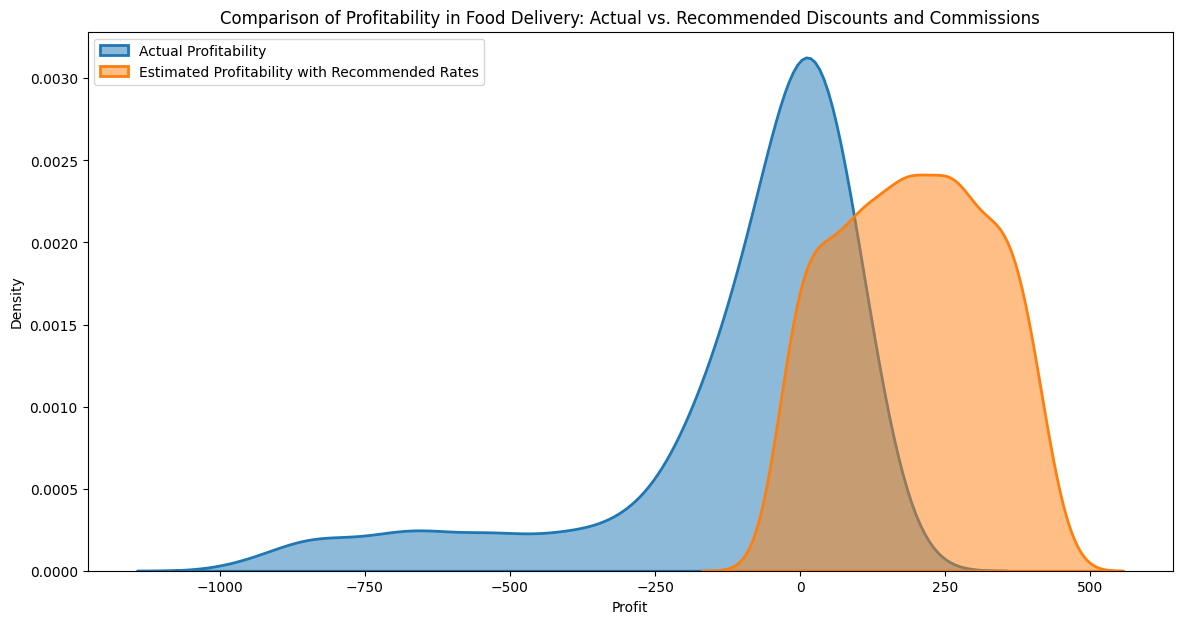

In [12]:
# simulate profitability with recommended discounts and commissions
recommended_commission_percentage = 30.0  # 30%
recommended_discount_percentage = 6.0    # 6%

# calculate the simulated commission fee and discount amount using recommended percentages
food_orders['Simulated Commission Fee'] = food_orders['Order Value'] * (recommended_commission_percentage / 100)
food_orders['Simulated Discount Amount'] = food_orders['Order Value'] * (recommended_discount_percentage / 100)

# recalculate total costs and profit with simulated values
food_orders['Simulated Total Costs'] = (food_orders['Delivery Fee'] +
                                        food_orders['Payment Processing Fee'] +
                                        food_orders['Simulated Discount Amount'])

food_orders['Simulated Profit'] = (food_orders['Simulated Commission Fee'] -
                                   food_orders['Simulated Total Costs'])

# visualizing the comparison
import seaborn as sns

plt.figure(figsize=(14, 7))

# actual profitability
sns.kdeplot(food_orders['Profit'], label='Actual Profitability', fill=True, alpha=0.5, linewidth=2)

# simulated profitability
sns.kdeplot(food_orders['Simulated Profit'], label='Estimated Profitability with Recommended Rates', fill=True, alpha=0.5, linewidth=2)

plt.title('Comparison of Profitability in Food Delivery: Actual vs. Recommended Discounts and Commissions')
plt.xlabel('Profit')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

The visualization compares the distribution of profitability per order using actual discounts and commissions versus the simulated scenario with recommended discounts (6%) and commissions (30%).

The actual profitability distribution shows a mix, with a significant portion of orders resulting in losses (profit < 0) and a broad spread of profit levels for orders. The simulated scenario suggests a shift towards higher profitability per order. The distribution is more skewed towards positive profit, indicating that the recommended adjustments could lead to a higher proportion of profitable orders.

*Food Delivery Cost and Profitability Analysis involves examining all the costs associated with delivering food orders, from direct expenses like delivery fees and packaging to indirect expenses like discounts offered to customers and commission fees paid by restaurants. By juxtaposing these costs against the revenue generated (primarily through order values and commission fees), the analysis aims to provide insights into how profitable the food delivery service is on a per-order basis.*